In [1]:
import gpytorch
import matplotlib.pyplot as plt
import torch
from torch import nn

from func_algorithms import *
from func_data_generation import *
from func_polygon import *
from utils import *
from warp_units import *

# from torchsummary import summary


dtype = torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
# device =  "cpu"
print("Using {} device".format(device))

import tqdm

torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2
from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

Using cuda device


In [2]:
class WarpModel(torch.nn.Sequential):
    def __init__(self):
        super(WarpModel, self).__init__()
        self.add_module(
            "axial_dim0", AxialWarpUnit(dim=0, res=50, grad=20, lims=[0, 1.0])
        )
        self.add_module(
            "axial_dim1", AxialWarpUnit(dim=1, res=50, grad=20, lims=[-1.0, 0])
        )
        self.add_module("rbf_seq1", rbfunit_sequential(res=2, ylim=[-1.0, 0.0]))
        self.add_module("rbf_seq2", rbfunit_sequential(res=3, ylim=[-1, 0]))
        self.add_module("mobius", MobiusWarpUnit())


class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, warp_model):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        #             self.covar_module = gpytorch.kernels.GridInterpolationKernel(
        #                 gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2)),
        #                 num_dims=2, grid_size=100
        #             )
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        #         self.covar_module = gpytorch.kernels.SpectralMixtureKernel(
        #             num_mixtures=4, ard_num_dims=2
        #         )
        #         self.covar_module2 = gpytorch.kernels.ScaleKernel(
        #             gpytorch.kernels.PolynomialKernel(1, active_dimes=[0])
        #             * gpytorch.kernels.PolynomialKernel(1, active_dimes=[1])
        #         )
        #         self.covar_module2 = gpytorch.kernels.ScaleKernel(
        #             gpytorch.kernels.PolynomialKernel(power=2)
        #         )
        self.covar_module2 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.space_transform = warp_model

        #         self.register_parameter(
        #             name="offset", parameter=torch.nn.Parameter(torch.zeros(1, 2))
        #         )
        self.w1 = 1
        self.w2 = 1

    def forward(self, x):
        # We're first putting our data through a deep net (feature extractor)
        # We're also scaling the features so that they're nice values
        projected_x = self.space_transform(x)
        projected_x = projected_x - projected_x.min(0)[0]
        projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

        mean_x = self.mean_module(x)
        covar_x = self.w1 * self.covar_module(
            projected_x
        ) + self.w2 * self.covar_module2(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
data_num = 5
sensor_num = 200  # [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# load data
data_filename = DATA_PATH + "/datasets_" + str(data_num) + ".hd5f"

if os.path.exists(data_filename):
    with h5py.File(data_filename, "r") as f1:
        coords = f1["coords"][...]
        true_rss = f1["true_rss"][...]
        observed_rss = f1["observed_rss"][...]
        train_X = f1["train_" + str(sensor_num) + "/train_X"][...]
        train_y = f1["train_" + str(sensor_num) + "/train_y"][...]
        idx = f1["train_" + str(sensor_num) + "/idx"][...]

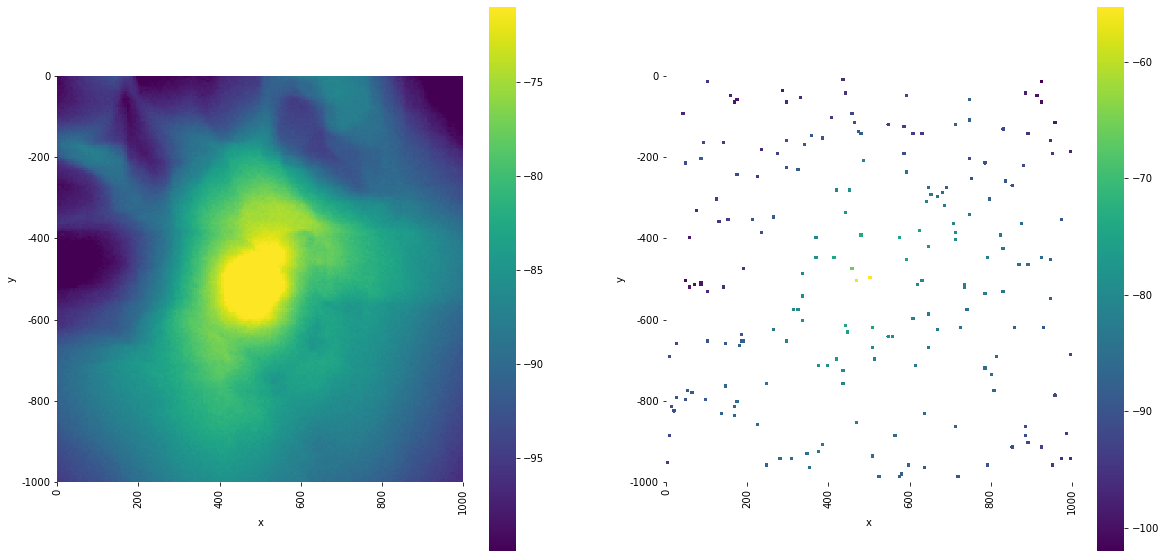

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_heatmap(coords, observed_rss, ax=axes[0], robust=True, cbar=True)
plot_heatmap(
    coords,
    observed_rss,
    mask_idx=idx,
    ax=axes[1],
    cbar=True,
)

In [5]:
# Normalize train_X to 0-1
data_X_tensor = torch.from_numpy(train_X).to(device) / 1000
coords_tensor = torch.from_numpy(coords).to(device) / 1000

train_y_tensor = torch.from_numpy(train_y).to(device)
train_y_mean = train_y_tensor.mean()
data_y_tensor = train_y_tensor - train_y_mean
# train_y_sigma = torch.sqrt(train_y_tensor.var())
# train_y_tensor = (train_y_tensor - train_y_mean) / train_y_sigma

In [6]:
train_num = int(sensor_num * 0.9)
train_X_tensor = data_X_tensor[0:train_num, :]
train_y_tensor = data_y_tensor[0:train_num]
test_X_tensor = data_X_tensor[train_num:, :]
test_y_tensor = data_y_tensor[train_num:]

In [7]:
test_X_tensor.shape

torch.Size([20, 2])

In [8]:
# Define and initialize model
warp_model = WarpModel().to(device)
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
gp_model = GPRegressionModel(
    train_x=train_X_tensor,
    train_y=train_y_tensor,
    likelihood=likelihood,
    warp_model=warp_model,
).to(device)
gp_model.likelihood.noise = 0.2
gp_model.covar_module2.base_kernel.lengthscale = 0.0828
gp_model.covar_module2.outputscale = 30.51

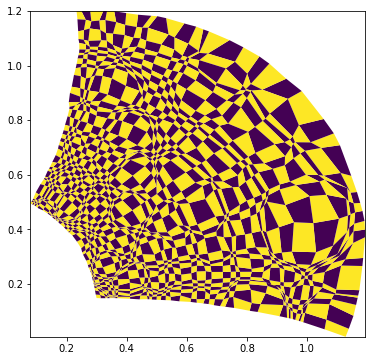

In [9]:
chessboard_from_model(warp_model)

In [10]:
for name, param in gp_model.named_parameters():
    print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")
# #     print(f"Layer:{name} | Size:{param.size()} |  \n")

Layer:likelihood.noise_covar.raw_noise | Size:torch.Size([1]) | Values : Parameter containing:
tensor([-1.5083], device='cuda:0', requires_grad=True) 

Layer:covar_module.raw_outputscale | Size:torch.Size([]) | Values : 0.0 

Layer:covar_module.base_kernel.raw_lengthscale | Size:torch.Size([1, 1]) | Values : Parameter containing:
tensor([[0.]], device='cuda:0', requires_grad=True) 

Layer:covar_module2.raw_outputscale | Size:torch.Size([]) | Values : 30.509999999999945 

Layer:covar_module2.base_kernel.raw_lengthscale | Size:torch.Size([1, 1]) | Values : Parameter containing:
tensor([[-2.4496]], device='cuda:0', requires_grad=True) 

Layer:space_transform.axial_dim0.weight_true | Size:torch.Size([1, 50]) | Values : Parameter containing:
tensor([[-4.4672e-01,  1.2802e-03,  6.4676e-01, -5.6844e-01, -1.4043e+00,
         -2.8077e-01,  1.3429e+00,  5.2364e-01,  1.4295e-01, -3.3839e-01,
         -8.3826e-01,  1.6383e-01, -1.9557e-01, -1.4973e+00,  4.6856e-01,
          5.4401e-01,  1.5657e+

In [11]:
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)


def train(epoch):
    gp_model.train()
    likelihood.train()

    for j in range(epoch):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = gp_model(train_X_tensor)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y_tensor)
        loss.backward()

        optimizer.step()
    writer.add_scalar("loss", loss.item(), i)
    writer.add_scalar(
        "length_scale1", gp_model.covar_module.base_kernel.lengthscale.item(), i
    )
    writer.add_scalar("output_scale1", gp_model.covar_module.outputscale.item(), i)
    #             writer.add_scalar("offset0", gp_model.offset[0, 0].item(), i)
    #             writer.add_scalar("offset1", gp_model.offset[0, 1].item(), i)
    writer.add_scalar("output_scale", gp_model.covar_module2.outputscale.item(), i)
    #             writer.add_scalar("offset0", gp_model.offset[0, 0].item(), i)
    #             writer.add_scalar("offset1", gp_model.offset[0, 1].item(), i)
    writer.add_scalar(
        "length_scale",
        gp_model.covar_module2.base_kernel.lengthscale.item(),
        i,
    )


#             writer.add_scalar(
#                 "output_scale", gp_model.covar_module2.outputscale.item(), i
#             )


def test():
    likelihood.eval()
    gp_model.eval()
    observed_pred = gp_model(test_X_tensor)
    mean = observed_pred.mean.detach() + train_y_mean
    mape = MAPE(test_y_tensor.cpu().numpy(), mean.cpu().numpy())
    writer.add_scalar(
        "mape",
        mape,
        i,
    )
    return mape

In [12]:
# Use the adam optimizer
optimizer = torch.optim.Adam(
    [
        #         {"params": gp_model.offset, "lr": 0.1},
        {"params": gp_model.space_transform.parameters()},
        {"params": gp_model.covar_module.parameters()},
        #         {"params": gp_model.covar_module2.raw_outputscale},
        {"params": gp_model.covar_module2.parameters()},
        #         {"params": gp_model.mean_module.parameters()},
        #         {"params": gp_model.likelihood.parameters()},
    ],
    lr=0.01,
)
gp_model.w1 = 1
gp_model.w2 = 1

In [13]:
now = datetime.now()
log_dir = "logs/warpgp/" + now.strftime("%Y%m%d-%H%M%S") + "/"
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(log_dir)

mape_store = 1000
iterator = tqdm.notebook.tqdm(range(10000))
for i in iterator:
    train(10)
    mape = test()
    if mape < mape_store:
        mape_store = mape
        state_dict = gp_model.state_dict()
        likelihood_state_dict = likelihood.state_dict()
        torch.save(
            {"model": state_dict, "likelihood": likelihood_state_dict}, "checkpoint.dat"
        )

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [161]:
# for name, param in gp_model.named_parameters():
#     print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")

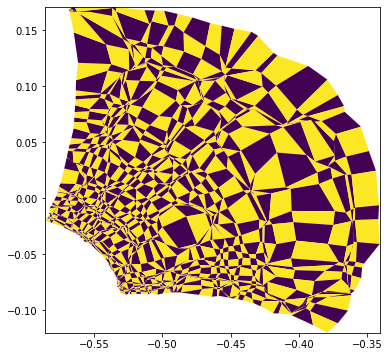

In [162]:
chessboard_from_model(warp_model)

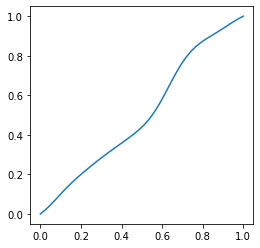

In [163]:
oned_map(warp_model.axial_dim0, dim=0)

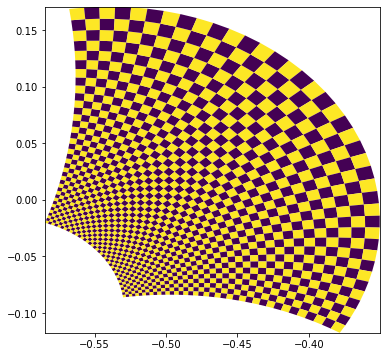

In [164]:
chessboard_from_model(warp_model.mobius)

In [165]:
# for name, param in gp_model.named_parameters():
#     print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")
#     print(f"Layer:{name} | Size:{param.size()} |  \n")

In [166]:
likelihood.eval()
gp_model.eval()
gp_model.w1 = 0.2
gp_model.w2 = 0.8
observed_pred = gp_model(coords_tensor)
mean = observed_pred.mean.detach() + train_y_mean
var = observed_pred.variance.detach()

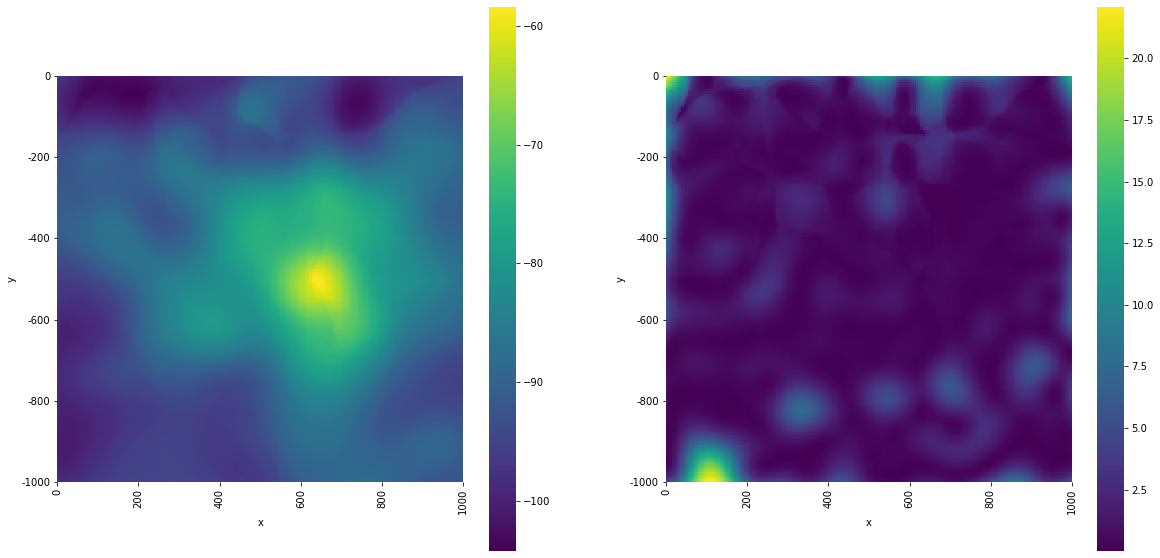

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
plot_heatmap(coords, mean, ax=axes[0], cbar=True)
# plot_heatmap(coords, mean, ax=axes[0], vmin=-103, vmax=-63, cbar=True)
plot_heatmap(coords, var, ax=axes[1], cbar=True)

In [168]:
save_result("result_4", "warpgp", sensor_num, mean.cpu().numpy(), var.cpu().numpy())

In [19]:
crps(mean.cpu().numpy(), mean.cpu().numpy(), var.cpu().numpy())

array([0.30624863, 0.30112584, 0.29627421, ..., 0.24914439, 0.25012484,
       0.25111229])

In [23]:
mse(mean.cpu().numpy(), mean.cpu().numpy(), squared=True)

0.0

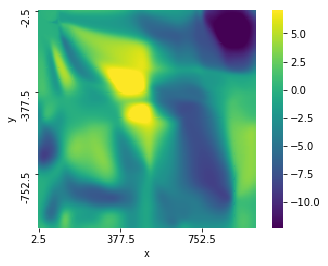

In [298]:
plot_heatmap(coords, mean)

In [21]:
point = torch.tensor([[2.5, -2.5]]).to(device)
warp_model(point)

In [1]:
coords

NameError: name 'coords' is not defined

In [353]:
gp_model.covar_module2

ProductKernel(
  (kernels): ModuleList(
    (0): LinearKernel(
      (raw_variance_constraint): Positive()
    )
    (1): LinearKernel(
      (raw_variance_constraint): Positive()
    )
  )
)